In [98]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2
from contextlib import suppress
import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns
import sys
import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib import style




#own libary
import nsidc 

from functions_pmrs import loadCM
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability
from functions_pmrs import NQT
from functions_pmrs import calc_performance_scores_new


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]

# start_date = datetim.datetime(2002, 5, 29) # Start of the AMSR-E period
# start_date = datetime.datetime(2004, 1, 1) # date after data recovery
# end_date = datetime.datetime(2009, 12, 31)  # only a few days to make a demonstration
# end_date = datetime.datetime(2004, 6, 30)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2002, 1, 2)

#---------------------------#---------------------------#---------------------------#---------------------------#

#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
# dQ['Date'] = pd.to_datetime(dQ['Date'])



#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None

year = 2009  #change year to select specific year to see [2002-2011]

# 25 km resolution PMSR DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

#select this next one for full period data string (whole DSMP period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/DMSP/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period

fns.sort()
ds = xr.open_mfdataset(fns)

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
sns.set()

<ipython-input-2-c516551fc8b9>:62: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:77: Fut

In [130]:

shift= 13
plot=0
rollingvalue = 6
selection= 5 # < number of months to be choosen

df = loadCM(points_xy,ds, rollingvalue)

plot=0
df = applyshift(df,rollingvalue,shift,plot)
df_nqt = NQT(df,plot, shift, location, rollingvalue)


plot=0
fits,res = calculateQR(df_nqt,selection,plot,shift,location)
pred = probability(df_nqt, fits, plot, shift,location)

df_nqt

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


,POI1,POI4
1988-01-01,1.000000,1.000000
1988-01-02,1.000000,1.000000
1988-01-03,1.000000,1.000000
1988-01-04,1.000000,1.000000
1988-01-05,1.000000,1.000000
...,...,...
2017-06-26,1.015530,1.028353
2017-06-27,1.012477,1.026795
2017-06-28,1.012477,1.025237
2017-06-29,1.012477,1.025237


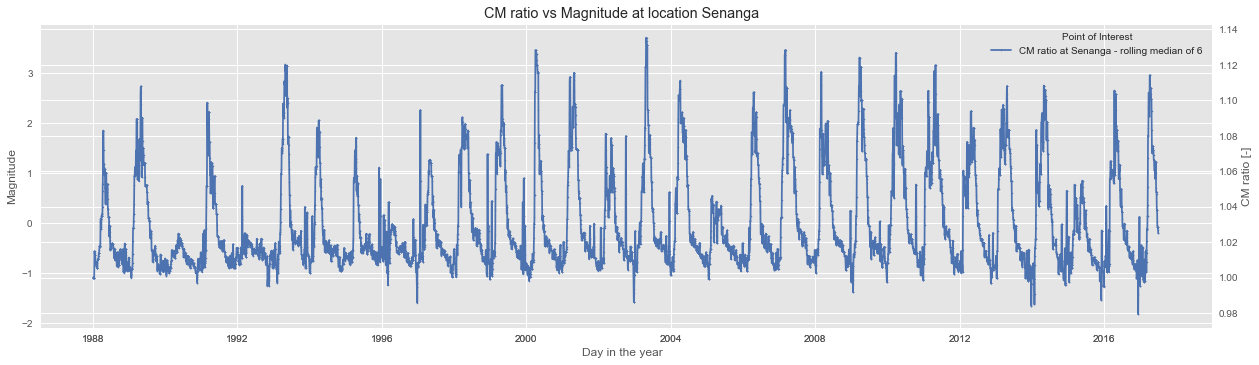

In [131]:

m = (df_nqt.POI4 - np.mean(df_nqt.POI4)) / np.std(df_nqt.POI4)


fig = plt.figure(figsize=(21,19))
ax1 = fig.add_subplot(311,frameon = True,)
# ax1.set_xticks(dQ.Senanga.index,dQ.Date.year) 
ax1.plot(m, color='w',linewidth =1, label = (f'Maginiturde at location {location}'))
ax1.set(xlabel=(f"Day in the year  "), ylabel="Magnitude",title=(f"CM ratio vs Magnitude at location {location}  "))
ax1.yaxis.tick_left() 

    
ax2 = fig.add_subplot(311, frameon=False, sharex=ax1)   # sharex=ax1,
ax2.plot(df_nqt.POI4 ,marker='.', markersize=3,  color='b', label = (f'CM ratio at {location} - rolling median of 6'))
ax2.set(ylabel="CM ratio [-]")
ax2.yaxis.set_label_position("right")
ax2.ylim =[-0.970, 1.020]
ax2.legend(loc=1, title ='Point of Interest',fancybox=True)
ax2.yaxis.tick_right()


In [157]:
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';', header=0, parse_dates=[0], index_col=0, squeeze=True, na_filter=True)#, parse_dates=['DATE'],index_col = ['DATE'])
# print(dQ.Senanga.to_string())
# dQ['Date'] = pd.to_datetime(dQ['Date'])
# dQ = dQ.set_index('Date')




dQ= dQ[dQ.index.year>1987]
dQ= dQ[dQ.index.year<2017]
df_nqt =  df_nqt[df_nqt.index.year<2017]
# dQ.set_index('Date')
print(dQ.index)
print(df_nqt.index)
# print(dQ.Senanga.to_string())

DatetimeIndex(['1988-01-01', '1988-02-01', '1988-03-01', '1988-04-01',
               '1988-05-01', '1988-06-01', '1988-07-01', '1988-08-01',
               '1988-09-01', '1988-10-01',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='Date', length=10593, freq=None)
DatetimeIndex(['1988-01-01', '1988-01-02', '1988-01-03', '1988-01-04',
               '1988-01-05', '1988-01-06', '1988-01-07', '1988-01-08',
               '1988-01-09', '1988-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=10593, freq=None)


In [158]:
# dQ = dQ.resample("M").median()

# print(dQ)
# df_total = df_nqt.merge(dQ,on='Date')
                       
df_total= pd.concat([dQ , df_nqt['POI4']], join="outer",  axis=1, ignore_index=False)

df_total.columns=['Q_Kalobo','Q_Senanga','POI_downstream']
# df_total=df_total.dropna()


# df_total.Q_Senanga= df_total.Q_Senanga.resample("SM").median()
df_total= df_total[df_total.index.month<6]
# df_total= df_total[df_total.index.month]




In [159]:
# calculate spearmans's rank correlation
coef_sr , p_sr = spearmanr(df_total['Q_Senanga'].values,df_total['POI_downstream'].values, nan_policy='omit')

# calculate kendall's correlation
coef_kendall, p_kendall = kendalltau(df_total['Q_Senanga'].values,df_total['POI_downstream'].values, nan_policy='omit') #, method = 'asymptotic'

#Covariance
covariance = np.cov(df_total['Q_Senanga'].values,df_total['POI_downstream'].values)

In [160]:
print('Spearmans correlation coefficient: %.3f' % coef_sr)
# interpret the significance
alpha = 0.05
if p_sr > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.6f' % p_sr)
else:
    print('Samples are correlated (reject H0) p=%.6f' % p_sr)
    
print('Kendall correlation coefficient: %.3f' % coef_kendall)
# interpret the significance
alpha = 0.05
if p_kendall > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.6f' % p_kendall)
else:
    print('Samples are correlated (reject H0) p=%.6f' % p_kendall)



Spearmans correlation coefficient: 0.538
Samples are correlated (reject H0) p=0.000000
Kendall correlation coefficient: 0.412
Samples are correlated (reject H0) p=0.000000


Text(0.5, 1.0, 'CM vs Discharge')

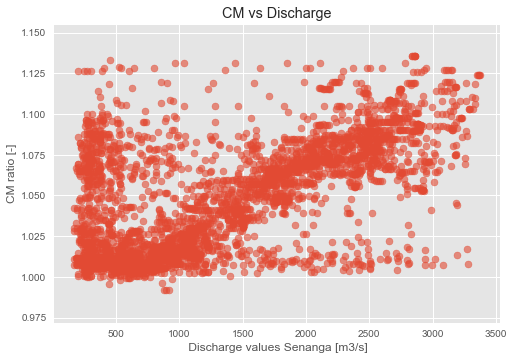

In [165]:
plt.scatter(df_total['Q_Senanga'].values,df_total['POI_downstream'].values,alpha=0.6)
style.use('ggplot')

plt.xlabel(' Discharge values Senanga [m3/s]')
plt.ylabel('CM ratio [-]')
plt.title('CM vs Discharge')

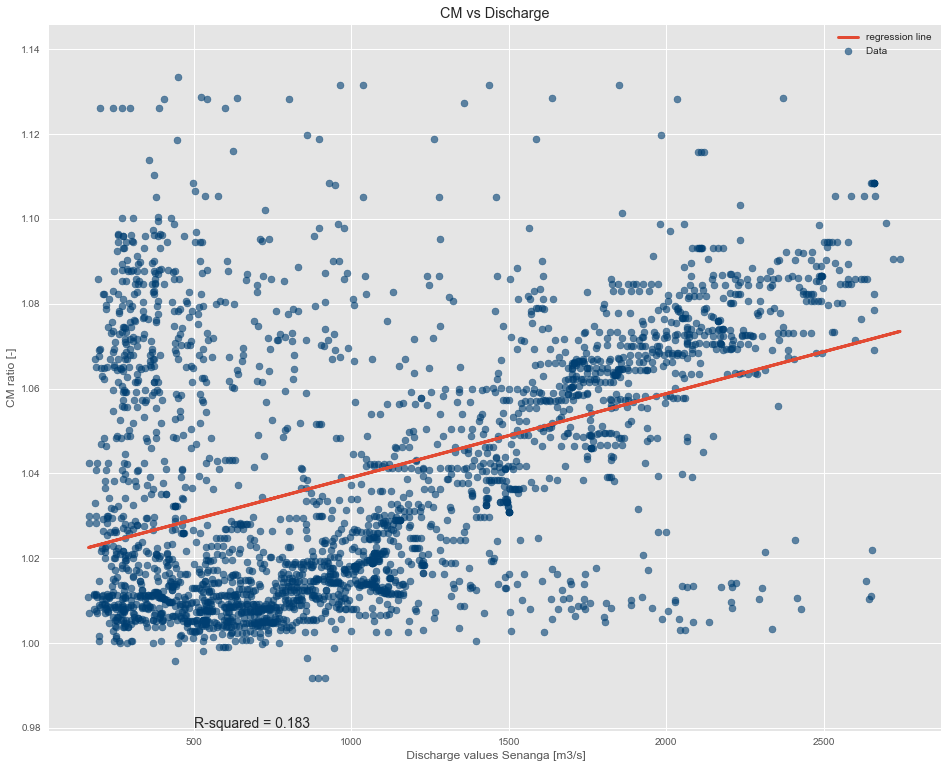

In [177]:
from sklearn.metrics import r2_score


df_total = df_total.dropna()
z = np.polyfit(df_total.Q_Senanga,df_total.POI_downstream,)


p = np.poly1d(z)
x = df_total.Q_Senanga
y = df_total.POI_downstream
coefficient_of_dermination = r2_score(y, p(x))


style.use('ggplot')
# style.use('seaborn')
plt.figure(figsize=(16,13))
plt.scatter(df_total['Q_Senanga'].values,df_total['POI_downstream'].values,alpha=0.6,color='#003F72', label='Data ')

_ = plt.plot(x, p(x), '-', label='regression line',linewidth =3)
plt.xlabel(' Discharge values Senanga [m3/s]')
plt.ylabel('CM ratio [-]')
plt.title('CM vs Discharge')
plt.text(500,0.98, f'R-squared = %0.3f' %coefficient_of_dermination, fontsize =14)
plt.legend()




1896913

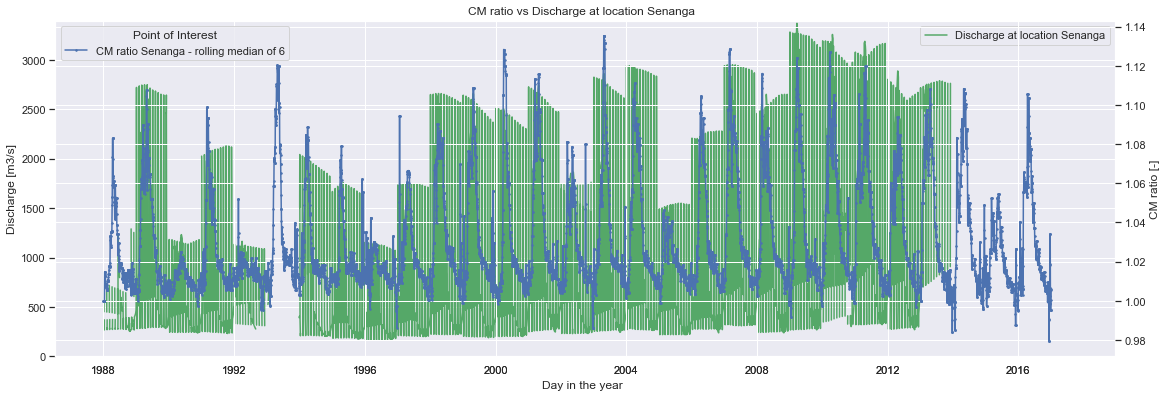

In [387]:
# NIET Gebruiken
fig = plt.figure(figsize=(19,21))

#     plt.plot(df[n] ,marker='.', markersize=1,label= (f'CM ratio at POI{n}- rolling median'))
ax1 = fig.add_subplot(311,frameon = True ,sharex =ax1)
# ax1.set_xticks (dQ.Senanga.index,dQ.Date.year) 

ax1.plot(df_total.Q_Senanga, color='g', label = (f'Discharge at location {location}'))
ax1.legend()
ax1.set(xlabel=(f"Day in the year  "), ylabel="Discharge [m3/s]",title=(f"CM ratio vs Discharge at location {location}  "),ylim =[0, 3400]);
ax1.yaxis.tick_left() 

    
    
ax2 = fig.add_subplot(311, frameon=False, sharex = ax1)
ax2.plot(df_total.POI_downstream ,marker='.', markersize=3, color='b', label = (f'CM ratio {location} - rolling median of {rollingvalue}'))
ax2.set(ylabel="CM ratio [-]")
ax2.yaxis.set_label_position("right")
ax2.ylim =[-0.970, 1.020]
ax2.legend(loc=2, title ='Point of Interest',fancybox=True)
ax2.yaxis.tick_right()

In [151]:

fig = plt.figure(figsize=(19,21))

#     plt.plot(df[n] ,marker='.', markersize=1,label= (f'CM ratio at POI{n}- rolling median'))
ax1 = fig.add_subplot(311, sharex=ax1)
# ax1.set_xticks(dQ.Senanga.index,dQ.Date.year) 

ax1.plot(dQ[["Senanga"]].resample("M").median(), color='g', label = (f'Discharge at location {location}'))
ax1.legend()
ax1.set(xlabel=(f"Day in the year  "), ylabel="Discharge [m3/s]",title=(f"CM ratio vs Discharge at location {location}  "),ylim =[0, 3400]);
ax1.yaxis.tick_left() 

    
    
ax2 = fig.add_subplot(311, frameon=False, sharex=ax1)   # sharex=ax1,
ax2.plot(df_nqt.POI4 ,marker='.', markersize=3, color='b', label = (f'CMvsQ_{location} - rolling median'))
ax2.set(ylabel="CM ratio [-]")
ax2.yaxis.set_label_position("right")
ax2.ylim =[-0.970, 1.020]
ax2.legend(loc=2, title ='Point of Interest',fancybox=True)
ax2.yaxis.tick_right()

ValueError: view limit minimum -36825.5 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36825.5 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 1368x1512 with 1 Axes>